In [77]:
from typing import *
import os
import pandas as pd
import gffutils
from collections import defaultdict
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pwd

/Users/yinzheng/Documents/GitHub/gem-analysis/parse_gff


In [3]:
df = pd.read_csv('functions.csv', header=0)

In [4]:
# replace 'host-associated' with 'host_associated' 
df = df.rename(columns={'host-associated': 'host_associated'})
# replace white space with '_'
df.columns = df.columns.str.replace(' ', '_')
# convert booleans to binary
# df = df * 1
df

,Unnamed:_0,taxonomy,host_associated,unknown_function,tail,DNA,transcription_regulation,head_and_packaging,lysis,moron,integration_and_excision,auxiliary_metabolic_gene_and_host_takeover,other,RNA_and_nucleotide_metabolism,connector,vf_amr
0,2029527003_3|2029527003.a:APTF_contig34915,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,True,6,9,1,0,0,1,0,0,0,0,1,2,0
1,2029527003_3|2029527003.a:APTF_contig46037,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,True,58,6,7,4,12,3,3,1,3,1,7,1,0
2,2035918003_3|2035918003.a:DPOL_contig02792,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,True,13,0,1,0,0,0,0,2,0,1,1,0,0
3,2035918003_3|2035918003.a:DPOL_contig20193,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,True,4,12,1,1,0,3,0,0,0,1,1,2,0
4,2084038008_1|2084038008.a:XAGC_contig32990,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,True,22,12,1,3,5,3,1,0,1,1,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303,3300011902_3|3300011902.a:Ga0120799_100007,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,False,45,8,4,5,10,1,0,1,0,0,4,1,0
2304,3300011902_3|3300011902.a:Ga0120799_100012,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,False,46,9,8,3,5,1,0,3,0,1,8,4,0
2305,3300011903_3|3300011903.a:Ga0121605_100009,d__Bacteria;p__Actinobacteriota;c__Actinobacte...,False,47,9,13,0,7,1,0,3,0,1,13,3,0
2306,3300011904_10|3300011904.a:Ga0121683_100178,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,False,43,3,6,2,6,0,0,1,0,2,6,4,0


In [5]:
# separate the data into two dataframes for a preliminary check
host = df[df['host_associated'] == True]
non_host = df[df['host_associated'] == False]

In [6]:
host.describe()

,unknown_function,tail,DNA,transcription_regulation,head_and_packaging,lysis,moron,integration_and_excision,auxiliary_metabolic_gene_and_host_takeover,other,RNA_and_nucleotide_metabolism,connector,vf_amr
count,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.000000,978.0
mean,30.854806,2.618609,2.747444,1.400818,3.286299,0.880368,0.726994,0.907975,0.726994,1.221881,2.747444,1.036810,0.0
std,21.528572,3.229334,2.782203,1.657117,2.608120,1.028261,1.046565,1.021628,1.046565,1.423897,2.782203,1.339379,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,14.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
50%,27.000000,2.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.0
75%,40.000000,4.000000,4.000000,2.000000,5.000000,1.000000,1.000000,1.750000,1.000000,2.000000,4.000000,2.000000,0.0
max,210.000000,20.000000,23.000000,9.000000,12.000000,5.000000,8.000000,9.000000,8.000000,12.000000,23.000000,8.000000,0.0


In [7]:
non_host.describe()

,unknown_function,tail,DNA,transcription_regulation,head_and_packaging,lysis,moron,integration_and_excision,auxiliary_metabolic_gene_and_host_takeover,other,RNA_and_nucleotide_metabolism,connector,vf_amr
count,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.0
mean,30.547368,4.233835,3.023308,1.907519,3.674436,1.342105,0.835338,1.048872,0.835338,1.174436,3.023308,1.398496,0.0
std,21.706218,4.231477,3.016668,1.861176,2.753209,1.465773,1.205374,1.072196,1.205374,1.417809,3.016668,1.563022,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,14.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
50%,26.000000,3.000000,2.000000,1.000000,4.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.0
75%,43.000000,7.000000,5.000000,3.000000,6.000000,2.000000,1.000000,2.000000,1.000000,2.000000,5.000000,3.000000,0.0
max,245.000000,28.000000,20.000000,13.000000,14.000000,7.000000,7.000000,9.000000,7.000000,14.000000,20.000000,6.000000,0.0


In [8]:
# give summary stats for each column for host associated vs non host associated


In [9]:

# '''
# input: annotation sets as list of binary labels over broad term categories
# output: similarity (dice or jaccard)
# dice = 2*|S1 ∩ S2| / (|S1| + |S2|)
# jaccard = |S1 ∩ S2| / |S1 U S2|
# '''
# # FIX THIS
# def sim_by_presence(ann1: List[int], ann2: List[int], metric="dice") -> float:
#     assert len(ann1) == len(ann2), "annotation sets must be same size"
#     if metric=="dice":
#         return 2*sum(a&b for a,b in zip(ann1, ann2)) / (sum(ann1) + sum(ann2))
#     elif metric=="jaccard":
#         return sum(a&b for a,b in zip(ann1, ann2)) / sum(a | b for a,b in zip(ann1, ann2))
#     else:
#         print("ERROR: metric must be 'jaccard' or 'dice'")


# def sim_by_count(...):
#     ...


In [10]:
'''
input:
    taxonomy_label: as given in 'ecosystem' column in mags metadata
    level: one of ["d","p","c","o","f","g","s"]
output: taxonomy up to given level
e.g. taxonomy_label = 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Solobacterium;s__'
     level = 'f'
     output = 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae'
'''
def get_taxonomy_level(taxonomy_label: str, level: str) -> str:
    taxa = ["d","p","c","o","f","g","s"]
    taxa_sep = taxonomy_label.split(";")
    last_ind = taxa.index(level)

    return ";".join(taxa_sep[:last_ind+1])

In [11]:
'''
functions of linear mixed-effects model
'''

'''
input: 
    df: output of "get_preprocessed_df:
    term: name of term categories that we want to test for; if None, will make a separate model for each
    taxonomy_level: one of ["d","p","c","o","f","g","s"]; will include that level as a random effect in the model
output: List of models, one for each given term
'''


def mixedlm(
    df: pd.DataFrame,
    terms: Union[List[str], str] = None,
    taxonomy_level: str = None,
) -> Dict:
    # Fit the nested ANOVA model
    if type(terms) != list:
        terms = [terms]

    assert "host_associated" in df.columns, "dataframe must contain 'host_associated' column"
    df_copy = df.copy()

    df_copy[taxonomy_level] = df["taxonomy"].apply(
        lambda x: get_taxonomy_level(x, taxonomy_level))

    out = {}

    for term in terms:
        if term not in df_copy.columns:
            print(
                f"{term} is not a valid term; {term} will not be included in output")

        model = smf.mixedlm(f'{term} ~ C(host_associated)', data=df_copy,
                            groups=df_copy[taxonomy_level], re_formula='~1').fit()
        # Print the model summary
        print(model.summary())

        out[term] = model

    return out

In [12]:
mixedlm_out = mixedlm(df, terms=['connector',
                                 'transcription_regulation', 'other', 'moron',
                                 'auxiliary_metabolic_gene_and_host_takeover', 'vf_amr',
                                 'integration_and_excision', 'unknown_function', 'head_and_packaging',
                                 'DNA', 'tail', 'RNA_and_nucleotide_metabolism', 'lysis'], taxonomy_level="g")
with open(f"mixedlm_summary.txt", "w") as text_file:
    for term, model in mixedlm_out.items():
        # save in txt file
        text_file.write(model.summary().as_text())
        text_file.write("\n\n")

/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     connector 
No. Observations:      2308        Method:                 REML      
No. Groups:            172         Scale:                  1.9661    
Min. group size:       1           Log-Likelihood:         -4107.6940
Max. group size:       183         Converged:              No        
Mean group size:       13.4                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.251    0.077 16.330 0.000  1.101  1.401
C(host_associated)[T.True] -0.178    0.101 -1.769 0.077 -0.375  0.019
Group Var                   0.206    0.029                           

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: trans

/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     other     
No. Observations:      2308        Method:                 REML      
No. Groups:            172         Scale:                  1.8551    
Min. group size:       1           Log-Likelihood:         -4065.0111
Max. group size:       183         Converged:              Yes       
Mean group size:       13.4                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.102    0.087 12.634 0.000  0.931  1.273
C(host_associated)[T.True] -0.032    0.108 -0.292 0.770 -0.243  0.180
Group Var                   0.385    0.155                           

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variab

/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1557: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1797: RuntimeWarning: invalid value encountered in divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conve

             Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    vf_amr
No. Observations:      2308       Method:                REML  
No. Groups:            172        Scale:                 0.0000
Min. group size:       1          Log-Likelihood:        inf   
Max. group size:       183        Converged:             No    
Mean group size:       13.4                                    
---------------------------------------------------------------
                           Coef. Std.Err. z P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept                  0.000                               
C(host_associated)[T.True] 0.000                               
Group Var                  0.000                               



/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: integration_and_excision
No. Observations: 2308    Method:             REML                    
No. Groups:       172     Scale:              1.0106                  
Min. group size:  1       Log-Likelihood:     -3333.6649              
Max. group size:  183     Converged:          No                      
Mean group size:  13.4                                                
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.906    0.052 17.269 0.000  0.803  1.009
C(host_associated)[T.True]  -0.097    0.069 -1.402 0.161 -0.232  0.038
Group Var                    0.084    0.019                           



/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

                Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   unknown_function
No. Observations:    2308      Method:               REML            
No. Groups:          172       Scale:                419.1662        
Min. group size:     1         Log-Likelihood:       -10291.9787     
Max. group size:     183       Converged:            No              
Mean group size:     13.4                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  30.176    1.120 26.940 0.000 27.981 32.372
C(host_associated)[T.True] -0.855    1.469 -0.582 0.561 -3.733  2.024
Group Var                  46.302    0.442                           

                Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  

In [48]:

'''
ANOVA functions
'''


def anova(
    df: pd.DataFrame,
    terms: Union[List[str], str] = None,
    taxonomy_level: str = None,
) -> Dict:

    df = df*1
    # Fit the nested ANOVA model
    if type(terms) != list:
        terms = [terms]

    assert "host_associated" in df.columns, "dataframe must contain 'host_associated' column"
    df_copy = df.copy()

    df_copy[taxonomy_level] = df["taxonomy"].apply(
        lambda x: get_taxonomy_level(x, taxonomy_level))

    out = {}

    for term in terms:
        if term not in df_copy.columns:
            print(
                f"{term} is not a valid term; {term} will not be included in output")

        model = ols(
            f"{term} ~ C(host_associated) + {taxonomy_level} + C(host_associated):{taxonomy_level}", data=df_copy,  re_formula='~1').fit()
        stats = sm.stats.anova_lm(model, typ=2)

        out[term] = (model, stats)

    return out

In [49]:
anova_out = anova(df, terms=['connector',   
                                'transcription_regulation', 'other', 'moron',
                                'auxiliary_metabolic_gene_and_host_takeover', 'vf_amr',
                                'integration_and_excision', 'unknown_function', 'head_and_packaging',
                                'DNA', 'tail', 
                                'RNA_and_nucleotide_metabolism', 
                                'lysis'], taxonomy_level="f") 
with open(f"anova_summary.txt", "w") as text_file:
    for term, (model, stats) in anova_out.items():
        # save in txt file
        text_file.write(model.summary().as_text())
        text_file.write("\n")
        text_file.write(stats.to_string())
        text_file.write("\n\n")

/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['re_formula']
  warnings.warn(msg, ValueWarning)
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 84, but rank is 72
  warnings.warn('covariance of constraints does not have full '
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 84, but rank is 13
  warnings.warn('covariance of constraints does not have full '
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['re_formula']
  warnings.warn(msg, ValueWarning)
/Users/yinzheng/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have f

In [52]:
# make dictionary that maps term to p-value for mixedlm and anova
pvals = {}
for term in anova_out.keys():
    anova = anova_out[term][1]['PR(>F)'].values
    mixedlm = mixedlm_out[term].pvalues
    # taxonomy, interaction, association grouped by taxonomy
    pvals[term] = [anova[1], anova[2], mixedlm['C(host_associated)[T.True]']]
pvals

{'connector': [1.0,
  9.016862780328987e-108,
  0.3270620502798233,
  0.0768882360112463],
 'transcription_regulation': [1.0,
  1.0,
  0.6821429863576985,
  0.04514722786917883],
 'other': [1.0,
  2.2143374140849464e-27,
  0.5836973559408504,
  0.7702014095032391],
 'moron': [1.0, 1.0, 0.9428355005719243, 0.5863218881456017],
 'auxiliary_metabolic_gene_and_host_takeover': [1.0,
  1.0,
  0.9428355005719243,
  0.5863218881456017],
 'vf_amr': [nan, nan, nan, nan],
 'integration_and_excision': [0.9999589427828061,
  7.546862092941418e-47,
  0.9263988405873026,
  0.16088534158757373],
 'unknown_function': [1.0,
  7.237457560822635e-08,
  0.09701737044155748,
  0.5605210512165332],
 'head_and_packaging': [0.999968377528088,
  1.0,
  0.014740696028465925,
  0.0687484452934923],
 'DNA': [1.0, 0.4089110665628095, 0.31811992765403757, 0.07032595557786482],
 'tail': [0.9999849945926321,
  1.0461439315086296e-21,
  0.4387850092221272,
  0.017812538814299388],
 'RNA_and_nucleotide_metabolism': [1.0

In [61]:
# # for each term, output a plot of the p-values
# for term in pvals.keys():
#     fig, ax = plt.subplots(figsize=(3,3),dpi=300)
#     ax.bar(['association', 'taxonomy', 'interaction', 'association grouped by taxonomy'], pvals[term])
#     # plot significance level
#     ax.axhline(y=0.05, color='r', linestyle='--')
#     ax.set_ylabel('p-value')
#     ax.set_title(f'p-values for {term}')


In [60]:
# set significance level
alpha = 0.05
# for each term, store whether the term is significant or not
significant = {}
for term in pvals.keys():
    if pvals[term][2] < alpha and pvals[term][3] < alpha:
        significant[term] = 'both'
    elif pvals[term][2] < alpha:
        significant[term] = 'anova'
    elif pvals[term][3] < alpha:
        significant[term] = 'mixedlm'
    else:
        significant[term] = 'neither'
significant

{'connector': 'neither',
 'transcription_regulation': 'mixedlm',
 'other': 'neither',
 'moron': 'neither',
 'auxiliary_metabolic_gene_and_host_takeover': 'neither',
 'vf_amr': 'neither',
 'integration_and_excision': 'neither',
 'unknown_function': 'neither',
 'head_and_packaging': 'anova',
 'DNA': 'neither',
 'tail': 'mixedlm',
 'RNA_and_nucleotide_metabolism': 'neither',
 'lysis': 'mixedlm'}

In [105]:
# host-assoc
def plot_fixed_effect(model):
    fig, ax = plt.subplots()
    fe_params = model.fe_params
    ax.bar(range(len(fe_params)), fe_params)
    ax.set_xlabel('Coefficient Index')
    ax.set_ylabel('Coefficient Value')
    ax.set_title('Fixed Effects Coefficients')
    plt.show()

# taxonomy
def plot_random_effects(model):
    random_effects = model.random_effects
    fig, ax = plt.subplots()
    # plot random effect values
    random_effects_vals = [int(value) for key, value in random_effects.items()]
    print(random_effects_vals)

def plot_residual_effects(model):
    residuals = model.resid
    fig, ax = plt.subplots()
    residuals.plot(kind='scatter', x=range(len(residuals)), y='resid', ax=ax)
    plt.show()

def plot_fitted_values(model):
    fitted_values = model.fittedvalues
    # Plot the fitted values
    fig, ax = plt.subplots()
    fitted_values.plot(kind='scatter', x=range(len(fitted_values)), y='fittedvalues', ax=ax)
    plt.show()

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/var/folders/62/_kzjxcq10d7727c9_qz6_ds80000gn/T/ipykernel_26022/163546388.py:16: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  random_effects_vals = [int(value) for key, value in random_effects.items()]


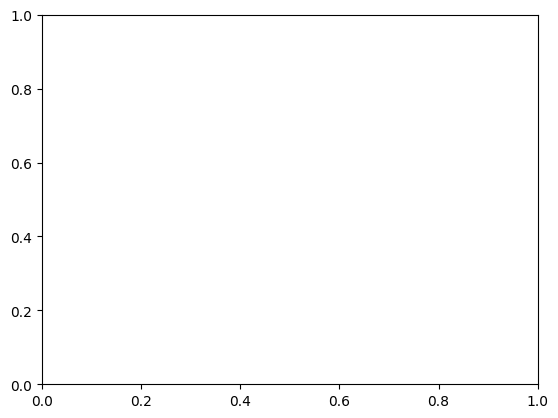

In [106]:
# plot mixedlm output
for term, model in mixedlm_out.items():
    # plot_fixed_effect(model)
    plot_random_effects(model)
    # plot_residual_effects(model)
    # plot_fitted_values(model)
    break

In [ ]:
mixedlm_out.items()